In [60]:
# Required Imports
import os, json, time
from pyproj import Transformer, Geod    
from wildfire.Reader import Reader as WFReader
import geojson
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)


SI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_si_per_year_csv')
EPA_AQI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_epa_aqi_per_year_csv')
FIRE_INPUT_PATH = output_paths.get('stage0_fire_json')

# Question 1

In [62]:
with open(FIRE_INPUT_PATH) as fire_file:
    fire_data_for_hist = geojson.load(fire_file)

In [63]:
fire_distances = []

for feature in fire_data_for_hist['features']:

    dist_from_memphis = feature.get('attributes', {}).get('distance')
    fire_distances.append(dist_from_memphis)

In [64]:
# Convert fire_distances to a DataFrame for easier analysis and plotting
distances_df = pd.DataFrame(fire_distances, columns=['distance_miles'])

# Calculate summary statistics
distance_summary = distances_df['distance_miles'].describe()
print("Distance Summary Statistics:")
print(distance_summary)

Distance Summary Statistics:
count    101906.000000
mean       1059.860947
std         526.912300
min           5.992876
25%         572.452124
50%        1127.416618
75%        1561.397625
max        1799.999235
Name: distance_miles, dtype: float64


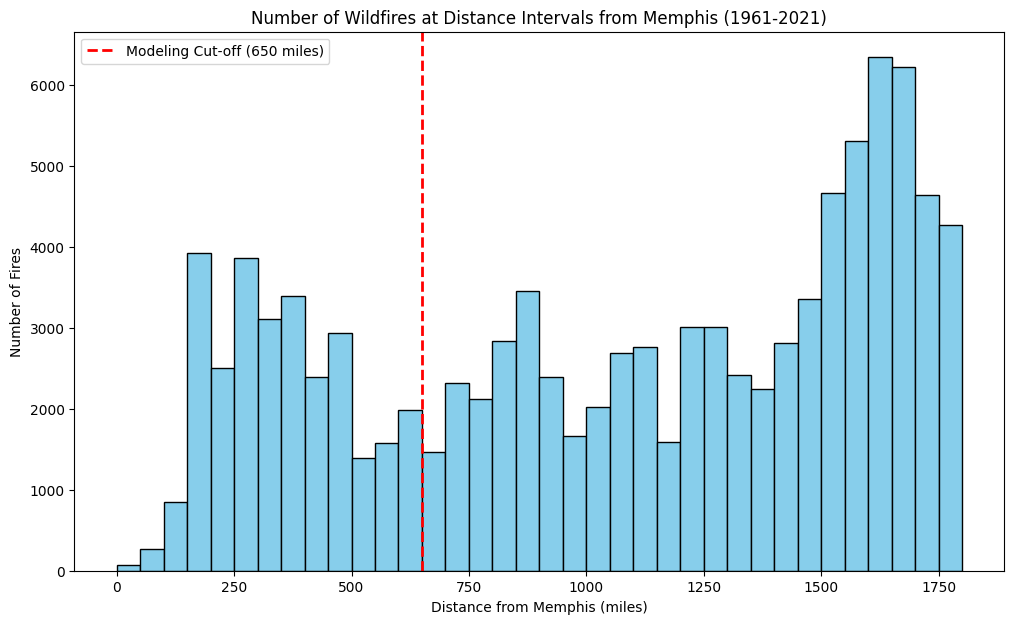

In [65]:
# Define the bin edges for every 50-mile interval up to 1800 miles
bins = list(range(0, 1801, 50))  # Creates bins: 0-50, 50-100, ..., up to 1750-1800

# Set the distance cut-off for modeling (replace with your specific cut-off if different)
modeling_distance_cutoff = 650

# Plot the histogram
plt.figure(figsize=(12, 7))
plt.hist(fire_distances, bins=bins, color='skyblue', edgecolor='black')
plt.axvline(x=modeling_distance_cutoff, color='red', linestyle='--', linewidth=2, label=f'Modeling Cut-off ({modeling_distance_cutoff} miles)')
plt.xlabel('Distance from Memphis (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Wildfires at Distance Intervals from Memphis (1961-2021)')
plt.legend()
plt.show()

## Question 2

In [78]:
per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)

#with open('intermediate_file_paths.json') as output_path_file:
#     output_paths = json.load(output_path_file)

# PER_YEAR_INPUT_PATH = output_paths.get('smoke_impacts_per_year_csv')

# per_year_df = pd.read_csv(PER_YEAR_INPUT_PATH)

In [79]:
# Display the column headers and basic information for the politician dataset
print("\nPer Year Smoke Imact + Acres Burned - Column Headers:")
print(per_year_df.columns)

print("\nPer Year Smoke Imact + Acres Burned - Basic Info:")
print(per_year_df.info())

print("\nPer Year Smoke Imact + Acres Burned - First 5 Rows:")
print(per_year_df.head())


Per Year Smoke Imact + Acres Burned - Column Headers:
Index(['fire_year', 'total_weighted_smoke_impact', 'total_acres_burned'], dtype='object')

Per Year Smoke Imact + Acres Burned - Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fire_year                    61 non-null     int64  
 1   total_weighted_smoke_impact  61 non-null     float64
 2   total_acres_burned           61 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.6 KB
None

Per Year Smoke Imact + Acres Burned - First 5 Rows:
   fire_year  total_weighted_smoke_impact  total_acres_burned
0       1961                     0.000000            0.000000
1       1962                     0.000000            0.000000
2       1963                     0.000000            0.000000
3       1964                     0.000591           28.4

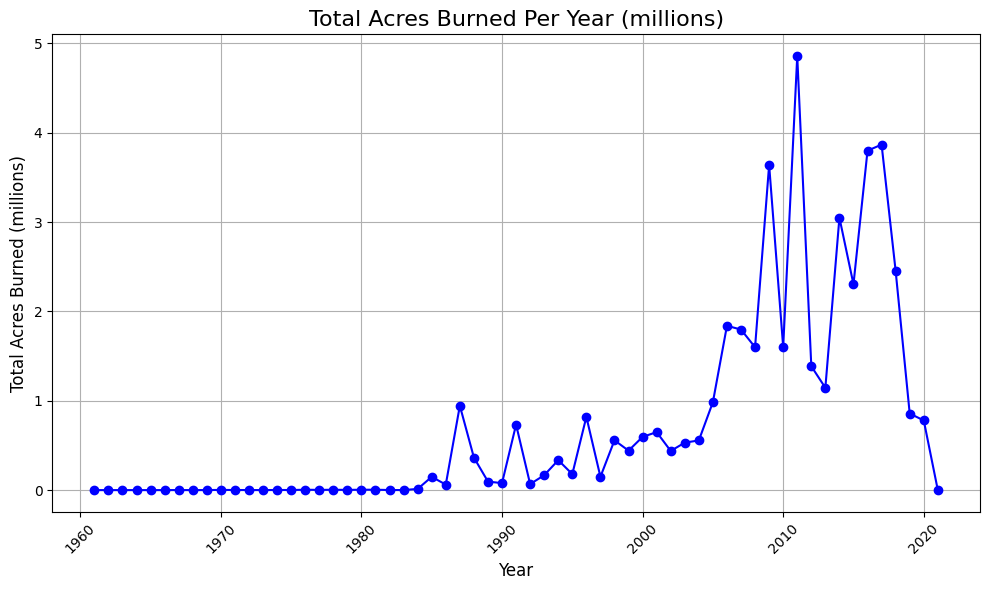

In [80]:
# Convert total acres burned to millions
per_year_df['total_acres_burned_millions'] = per_year_df['total_acres_burned'] / 1e6


# Plotting the time series of total acres burned per year in millions
plt.figure(figsize=(10, 6))

# Plot total acres burned (in millions) against the year
plt.plot(per_year_df['fire_year'], per_year_df['total_acres_burned_millions'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Total Acres Burned Per Year (millions)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Acres Burned (millions)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 3

In [81]:
# year,site_code,site_name,pollutant_number,pollutant_name,average_aqi

epa_aqi_df = pd.read_csv(EPA_AQI_PER_YEAR_INPUT_PATH)
si_per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)

In [82]:
print(epa_aqi_df)

     year  site_code                                          site_name  \
0    1972         21                              Frayser Ozone Monitor   
1    1972         21                              Frayser Ozone Monitor   
2    1972         21                              Frayser Ozone Monitor   
3    1973         21                              Frayser Ozone Monitor   
4    1973         21                              Frayser Ozone Monitor   
..    ...        ...                                                ...   
397  2021         75                                 Memphis NCORE site   
398  2021        100  Near Road Site at Southwest Tennessee Communit...   
399  2021        100  Near Road Site at Southwest Tennessee Communit...   
400  2021        100  Near Road Site at Southwest Tennessee Communit...   
401  2021       1004                           Edmund Orgill Park Ozone   

     pollutant_number            pollutant_name  average_aqi  
0               42101           Carb

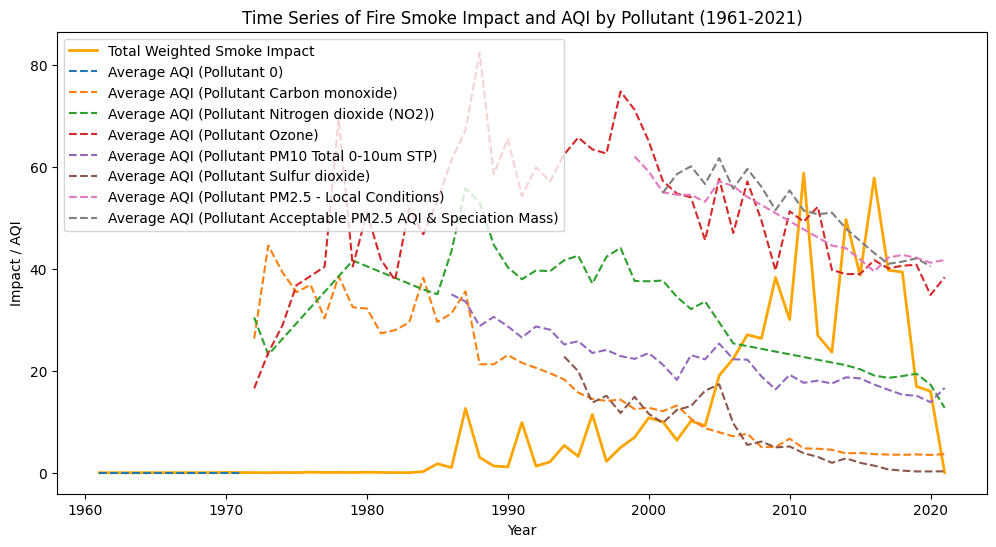

In [83]:
# Group AQI by pollutant and calculate the average AQI per pollutant per year
aqi_by_pollutant_df = epa_aqi_df.groupby(['year', 'pollutant_name'], as_index=False)['average_aqi'].mean()

# Merge datasets on 'year' column
combined_df_2 = pd.merge(si_per_year_df, aqi_by_pollutant_df, left_on='fire_year', right_on='year', how='outer')

# Create a DataFrame containing all years from 1961 to 2021
all_years_df = pd.DataFrame({'fire_year': range(1961, 2022)})

# Merge with all_years_df to include all years, filling missing values with zero
combined_df_3 = pd.merge(all_years_df, combined_df_2, on='fire_year', how='left').fillna(0)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Total Weighted Smoke Impact
plt.plot(combined_df_3['fire_year'], combined_df_3['total_weighted_smoke_impact'], label='Total Weighted Smoke Impact', color='orange', linewidth=2)

# Plot Average AQI for each pollutant
for pollutant in combined_df_3['pollutant_name'].unique():
    # Filter the DataFrame for the current pollutant
    pollutant_data = combined_df_3[combined_df_3['pollutant_name'] == pollutant]
    plt.plot(
        pollutant_data['fire_year'], 
        pollutant_data['average_aqi'], 
        label=f'Average AQI (Pollutant {(pollutant)})', 
        linestyle='--', linewidth=1.5
    )

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Impact / AQI')
plt.title('Time Series of Fire Smoke Impact and AQI by Pollutant (1961-2021)')
plt.legend()
plt.show()


In [84]:
si_per_year_summary = si_per_year_df['total_weighted_smoke_impact'].describe()
print("Summary Statistics:")
print(si_per_year_summary)

Summary Statistics:
count    61.000000
mean     10.602648
std      15.554228
min       0.000000
25%       0.027839
50%       2.142253
75%      15.994830
max      58.811352
Name: total_weighted_smoke_impact, dtype: float64


In [73]:
# # Group by 'year', 'pollutant_number', and 'pollutant_name' and calculate the average AQI
# annual_aqi_df = epa_aqi_df.groupby(
#     ['year', 'pollutant_number', 'pollutant_name'],
#     as_index=False
# )['average_aqi'].mean()


In [74]:
# # Calculate summary statistics
# aqi_summary = annual_aqi_df['average_aqi'].describe()
# print("Summary Statistics:")
# print(aqi_summary)

In [85]:
# Optionally, if you need an overall AQI average per year (across all pollutants), use this line:
annual_aqi_per_year_df = epa_aqi_df.groupby('year', as_index=False)['average_aqi'].mean()
#annual_aqi_per_year_df = annual_aqi_per_year_df.rename(columns={'aqi': 'average_aqi'})

# Calculate summary statistics
aqi_summary = annual_aqi_per_year_df['average_aqi'].describe()
print("Summary Statistics:")
print(aqi_summary)

print(annual_aqi_per_year_df)

Summary Statistics:
count    50.000000
mean     34.639301
std       7.011836
min      23.595310
25%      29.299030
50%      35.137991
75%      38.875546
max      54.080814
Name: average_aqi, dtype: float64
    year  average_aqi
0   1972    24.452474
1   1973    31.878805
2   1974    34.125749
3   1975    36.106710
4   1976    37.737000
5   1977    35.375429
6   1978    54.080814
7   1979    36.771014
8   1980    41.640844
9   1981    34.565198
10  1982    32.886791
11  1983    40.683321
12  1984    41.226605
13  1985    40.220562
14  1986    43.935831
15  1987    49.196513
16  1988    48.217691
17  1989    39.178401
18  1990    41.041825
19  1991    36.039555
20  1992    38.244131
21  1993    36.834527
22  1994    33.504852
23  1995    33.657475
24  1996    30.814404
25  1997    31.473175
26  1998    33.647175
27  1999    34.900552
28  2000    35.763307
29  2001    36.614807
30  2002    35.632844
31  2003    39.948165
32  2004    37.630784
33  2005    44.944290
34  2006    39.086018
35

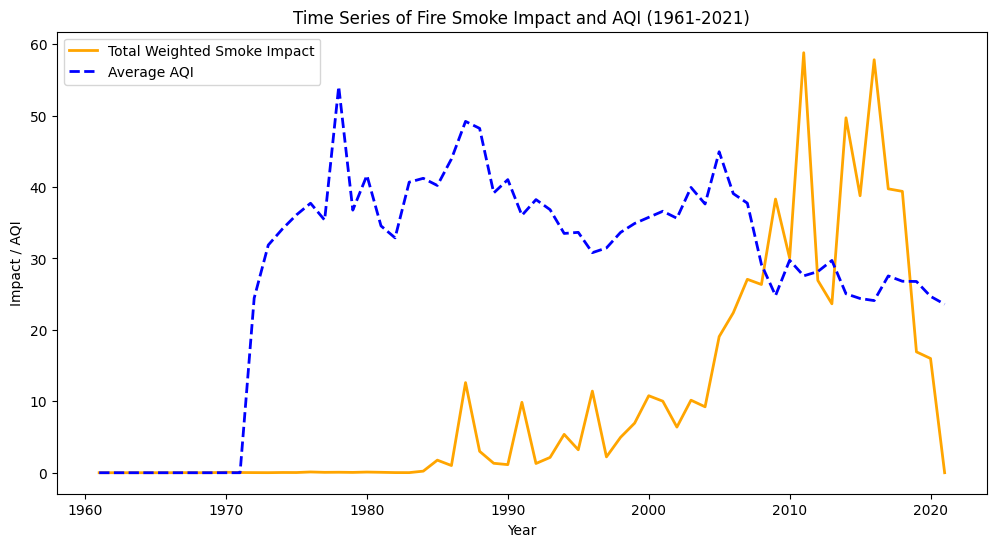

In [86]:
# Merge datasets on 'year' column
combined_df = pd.merge(si_per_year_df, annual_aqi_per_year_df, left_on='fire_year', right_on='year', how='outer')

# Create a DataFrame containing all years from 1961 to 2021
all_years_df = pd.DataFrame({'fire_year': range(1961, 2022)})

# Merge with all_years_df to include all years, filling missing values with zero
combined_df = pd.merge(all_years_df, combined_df, on='fire_year', how='left').fillna(0)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Total Weighted Smoke Impact
plt.plot(combined_df['fire_year'], combined_df['total_weighted_smoke_impact'], label='Total Weighted Smoke Impact', color='orange', linewidth=2)

# Plot Average AQI
plt.plot(combined_df['fire_year'], combined_df['average_aqi'], label='Average AQI', color='blue', linestyle='--', linewidth=2)

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Impact / AQI')
plt.title('Time Series of Fire Smoke Impact and AQI (1961-2021)')
plt.legend()
